In [6]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff
from sklearn.linear_model import LinearRegression

In [7]:
DATA_PATH = "../data"
target_sport_data = pd.read_parquet(DATA_PATH+"/target_sport_data_mt.parquet",engine="fastparquet")
target_sport_data['upload_year_month'] = target_sport_data['upload_date'].dt.to_period('M') 

In [4]:
target_sport_data.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year_month,engagement_rate
0,Sports,UCzTF8VGf1wY4juDDmDqgxWA,2019-11-15 10:33:44.027819,hello peeps a quick attempt at filming on my g...,0.0,_oJ_HVk59qA,169,13.0,"gopro,hero,hero4,football,first,attempt,gopro ...",FIRST GOPRO HERO4 VIDEO SHOOTOUT,2016-03-08,342.0,2016-03,0.038012
1,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:42:32.431690,The England national football team is in disar...,1.0,CpE_LBqzh40,162,4.0,"fabio capello,england,john terry,football asso...",England football team in disarray,2012-02-09,351.0,2012-02,0.014245
2,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:03.228877,English football fans have reacted with shock ...,4.0,ftiJ8TfapoI,149,14.0,"world_cup,spain,portugal,russia,roshan muhamme...",England humiliated over World Cup bid,2010-12-02,4038.0,2010-12,0.004458
3,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:13.888521,"The world soccer governing body, Fifa, has ack...",1.0,Pd9WmFgLbZg,138,0.0,"world_cup,johannesburg,joburg,roshan muhammed ...",How good is the Jabulani?,2010-07-29,222.0,2010-07,0.004505
4,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:16.292029,The whole continent of Africa is in mourning a...,0.0,AldYoZRbT2w,141,0.0,"world_cup,ghana,vuvuzela,south africa,roshan m...",Africans heartbroken after Ghana World Cup exit,2010-07-29,193.0,2010-07,0.000000


In [8]:
target_sports = [
    "football","basketball","wrestling","soccer","boxing","hockey","mma","golf","baseball","tennis","cricket","rugby","gymnastics"
,"volleyball","skating","karate"]

In [15]:
def sport_analysis(data_all,data_sport,sport_name=None):
    monthly_count = data_sport.groupby('upload_year_month').size()
    # plt.figure(figsize=(12, 8))
    # monthly_count.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

    # plt.title('Monthly Upload Counts for {}'.format(sport_name), fontsize=16)
    # plt.xlabel('Month', fontsize=14)
    # plt.ylabel('Number of Uploads', fontsize=14)
    # # plt.legend(title='Sports', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.grid(True)
    # plt.tight_layout()
    # # plt.ylim(0,2000)
    # plt.show()
    # autocorrelation = monthly_count.autocorr(lag=1)
    # print("Autocorrelation: ", autocorrelation)


    #------------------------------
    print("periodic analysis")
    # window = np.hanning(len(monthly_count))  # ハニング窓を使用（他の窓関数も可能）
    # windowed_data = monthly_count * window   # 信号に窓関数を掛ける

    # # フーリエ変換の計算
    # fft_values = np.fft.fft(windowed_data)
    # フーリエ変換の計算
    fft_values = np.fft.fft(monthly_count)

    # 振幅スペクトルを取得（絶対値）
    fft_amplitude = np.abs(fft_values)
    fft_amplitude /= len(monthly_count)
    print("len",len(monthly_count))

    # 周波数軸を計算
    frequencies = np.fft.fftfreq(len(fft_values))

    # 正の周波数のみを使用
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_amplitudes = fft_amplitude[:len(fft_amplitude)//2]

    # 周期（月数）に変換
    periods = 1 / positive_frequencies

    # 周期が無限大になる値（周波数が0の場合）を除去
    periods = periods[1:]  # 周波数0の部分を除く
    positive_amplitudes = positive_amplitudes[1:]  # 同様に振幅も除去
    
    threshold = 10
    filtered_periods = periods[positive_amplitudes >= threshold]
    filtered_amplitudes = positive_amplitudes[positive_amplitudes >= threshold]
    print(filtered_periods)
    print(filtered_amplitudes)
    filtered_periods=filtered_periods[1:]
    filtered_amplitudes=filtered_amplitudes[1:]

    # プロット
    plt.figure(figsize=(12, 8))
    # plt.bar(filtered_periods, filtered_amplitudes, width=0.5, color='blue')
    plt.stem(filtered_periods, filtered_amplitudes, linefmt='#e50000', markerfmt='o', basefmt='#e50000')
    plt.title('Frequency Spectrum, {}'.format(sport_name), fontsize=16)
    plt.xlabel('Period (Months)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    # plt.yscale("log")
    plt.xlim(0,60)
    plt.ylim(0,1000)
    plt.grid(True)

    # x軸のラベルを細かく調整
    plt.xticks(np.arange(0, 60 + 1, step=3), rotation=45)

    plt.tight_layout()
    plt.show()
    #------------------------------

    # total_sports_videos = data_all.groupby('upload_year_month').size()

    # sport_video_count = data_sport.groupby('upload_year_month').size()

    # golf_trend = (sport_video_count / total_sports_videos).fillna(0)  # NaNを0で置き換える
    # plt.figure(figsize=(12, 6))
    # golf_trend.plot(kind='line', figsize=(12, 6), colormap='tab20', linewidth=2)

    # plt.title('{} Video Upload Trends'.format(sport_name))
    # plt.xlabel('Month')
    # plt.ylabel('Proportion of {} related video'.format(sport_name))
    # plt.xticks(rotation=45)
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

    # #-----------------------------
    # # user engagement
    # monthly_engagement = data_sport.groupby('upload_year_month')['engagement_rate'].agg(['mean', 'median']).reset_index()

    # tick_positions = range(0, len(monthly_engagement), 4)
    # plt.figure(figsize=(12, 6))
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['mean'], marker='o', label='Mean Engagement Rate')
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['median'], marker='s', label='Median Engagement Rate', linestyle='--')
    # plt.title('Monthly Engagement Rate of {}'.format(sport_name))
    # plt.xlabel('Month')
    # plt.ylabel('Engagement Rate')
    # plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)  # ラベルを間引く
    # plt.legend()
    # plt.grid()
    # plt.ylim(0,0.05)
    # plt.tight_layout()
    # plt.show()

    # #-----------------------------
    # # q score
    # data_sport['q_score']=(data_sport['like_count'] - data_sport['dislike_count']) / (data_sport['like_count'] + data_sport['dislike_count'])
    # monthly_engagement = data_sport.groupby('upload_year_month')['q_score'].agg(['mean', 'median']).reset_index()

    # tick_positions = range(0, len(monthly_engagement), 4)
    # plt.figure(figsize=(12, 6))
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['mean'], marker='o', label='Mean Q score Rate')
    # plt.plot(monthly_engagement['upload_year_month'].astype(str), monthly_engagement['median'], marker='s', label='Median Q score Rate', linestyle='--')
    # plt.title('Monthly Q score of {}'.format(sport_name))
    # plt.xlabel('Month')
    # plt.ylabel('Q score')
    # plt.xticks(tick_positions, monthly_engagement['upload_year_month'].astype(str).iloc[tick_positions], rotation=45)  # ラベルを間引く
    # plt.legend()
    # plt.grid()
    # plt.tight_layout()
    # plt.show()

    #-------------------------------------
    # how many channels are active over time???

    

periodic analysis
len 162
[162.          81.          54.          40.5         32.4
  27.          23.14285714  20.25        18.          16.2
  14.72727273  13.5         12.46153846  11.57142857  10.8
  10.125        9.52941176   9.           8.52631579   8.1
   7.71428571   7.36363636   7.04347826   6.75         6.48
   6.23076923   6.           5.78571429   5.5862069    5.4
   5.22580645   5.0625       4.90909091   4.76470588   4.62857143
   4.5          4.37837838   4.26315789   4.15384615   4.05
   3.95121951   3.85714286   3.76744186   3.68181818   3.6
   3.52173913   3.44680851   3.375        3.30612245   3.24
   3.17647059   3.11538462   3.05660377   3.           2.94545455
   2.89285714   2.84210526   2.79310345   2.74576271   2.7
   2.6557377    2.61290323   2.57142857   2.53125      2.49230769
   2.45454545   2.41791045   2.38235294   2.34782609   2.31428571
   2.28169014   2.25         2.21917808   2.18918919   2.16
   2.13157895   2.1038961    2.07692308   2.05063291   2.

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


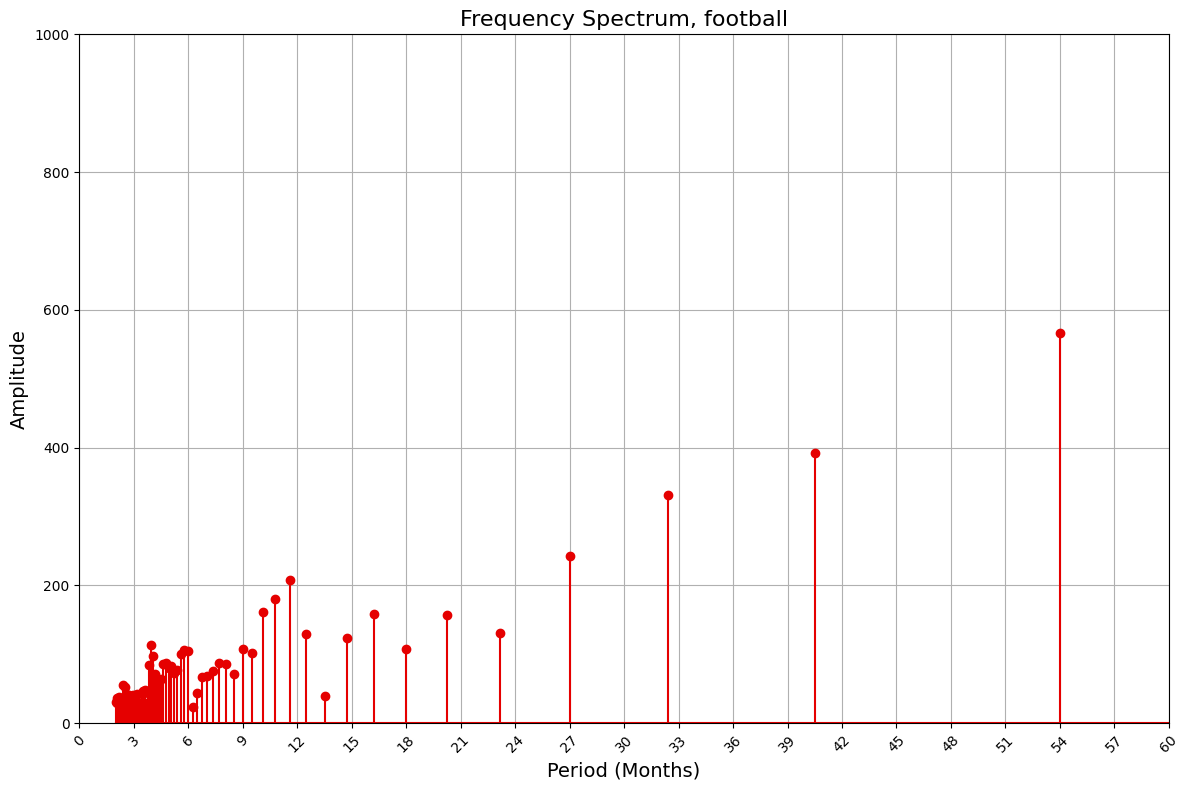

periodic analysis
len 162
[162.          81.          54.          40.5         32.4
  27.          23.14285714  20.25        18.          16.2
  14.72727273  13.5         12.46153846  11.57142857  10.8
  10.125        9.52941176   9.           8.52631579   8.1
   7.71428571   7.36363636   7.04347826   6.75         6.48
   6.23076923   6.           5.78571429   5.5862069    5.4
   5.22580645   5.0625       4.90909091   4.76470588   4.62857143
   4.5          4.37837838   4.26315789   4.15384615   4.05
   3.95121951   3.85714286   3.76744186   3.68181818   3.6
   3.52173913   3.44680851   3.375        3.24         3.17647059
   3.11538462   3.05660377   3.           2.94545455   2.84210526
   2.79310345   2.74576271   2.7          2.6557377    2.61290323
   2.57142857   2.53125      2.49230769   2.45454545   2.41791045
   2.38235294   2.34782609   2.31428571   2.25         2.21917808
   2.16         2.13157895   2.1038961    2.05063291   2.025     ]
[1334.12374037  732.73597116  415.297

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


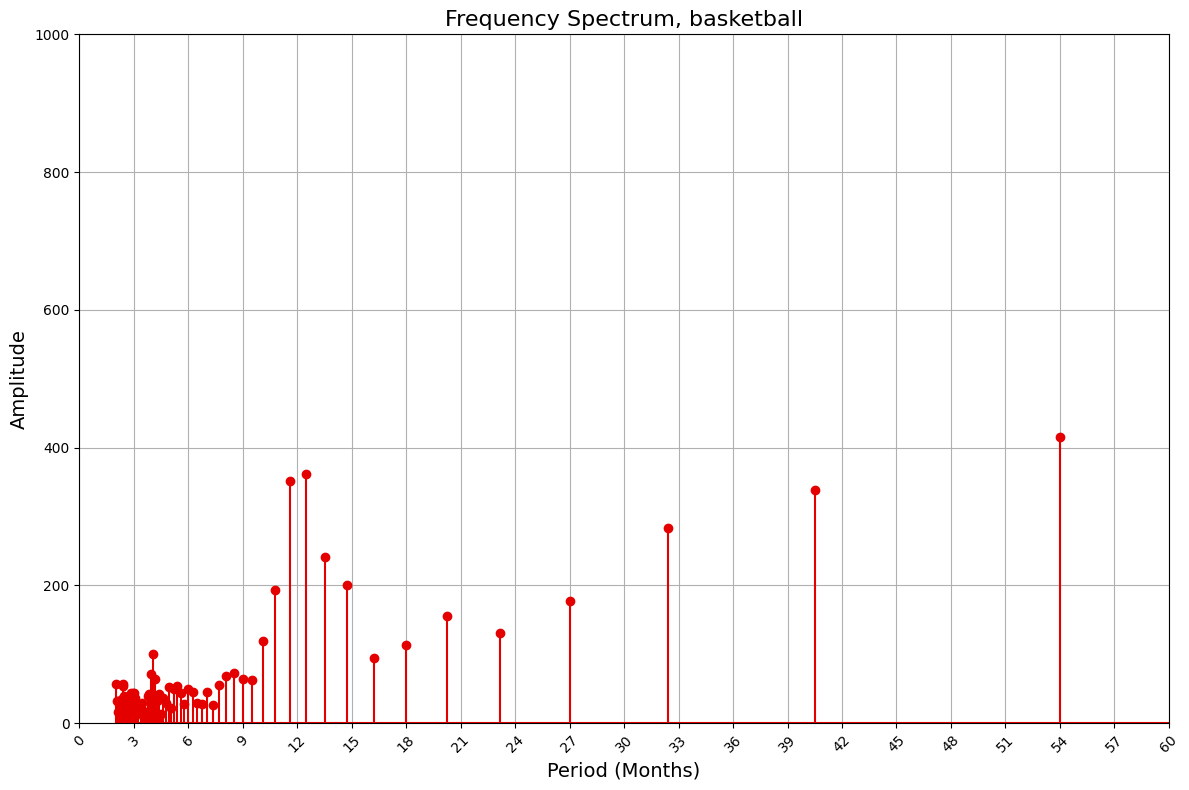

periodic analysis
len 166
[166.          83.          55.33333333  41.5         33.2
  27.66666667  23.71428571  20.75        18.44444444  16.6
  15.09090909  13.83333333  12.76923077  11.85714286  11.06666667
  10.375        9.76470588   9.22222222   8.73684211   8.3
   7.9047619    7.54545455   7.2173913    6.91666667   6.64
   6.38461538   6.14814815   5.92857143   5.72413793   5.53333333
   5.35483871   5.1875       5.03030303   4.88235294   4.74285714
   4.61111111   4.48648649   4.36842105   4.25641026   4.15
   4.04878049   3.95238095   3.86046512   3.77272727   3.68888889
   3.60869565   3.53191489   3.45833333   3.3877551    3.32
   3.25490196   3.19230769   3.13207547   3.07407407   3.01818182
   2.96428571   2.9122807    2.86206897   2.81355932   2.76666667
   2.72131148   2.67741935   2.63492063   2.59375      2.55384615
   2.51515152   2.47761194   2.44117647   2.4057971    2.37142857
   2.33802817   2.30555556   2.2739726    2.24324324   2.21333333
   2.18421053   2.15584

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


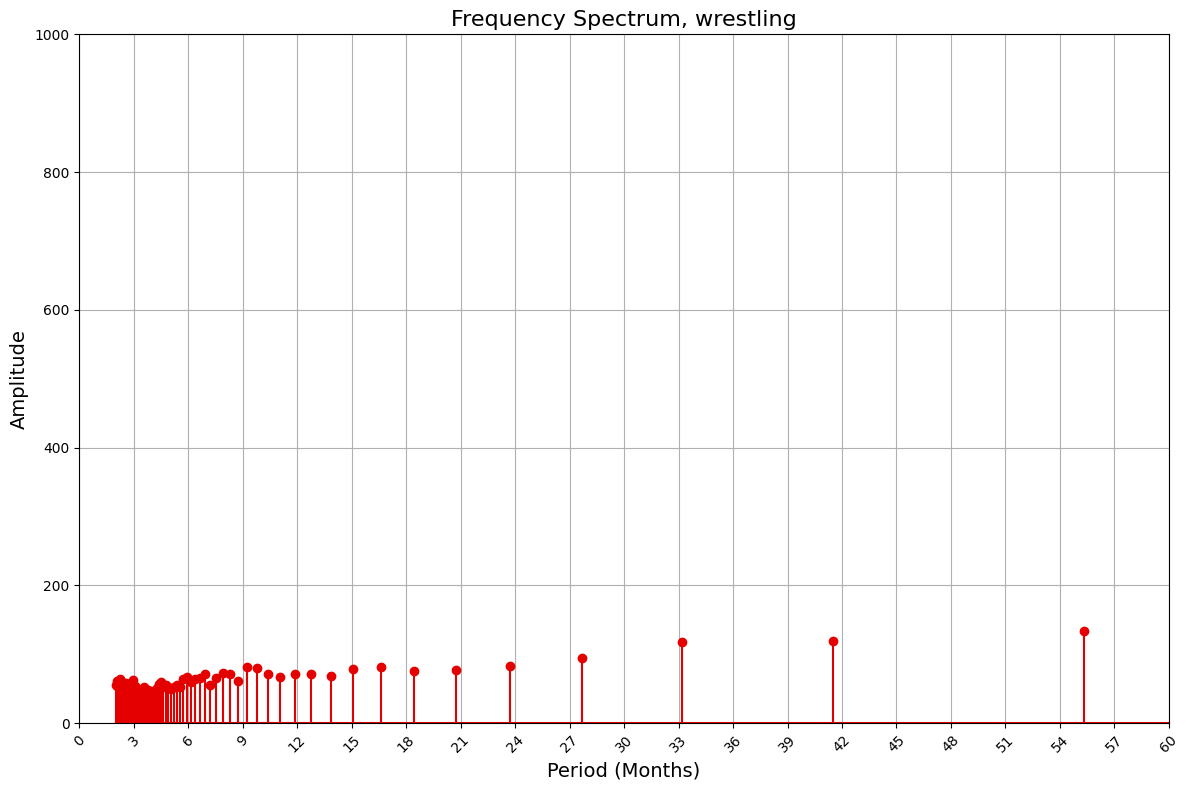

periodic analysis
len 164
[164.          82.          54.66666667  41.          32.8
  27.33333333  23.42857143  20.5         18.22222222  16.4
  14.90909091  13.66666667  12.61538462  11.71428571  10.93333333
  10.25         9.64705882   9.11111111   8.63157895   8.2
   7.80952381   7.45454545   7.13043478   6.83333333   6.56
   6.30769231   6.07407407   5.85714286   5.65517241   5.46666667
   5.29032258   5.125        4.96969697   4.82352941   4.68571429
   4.55555556   4.43243243   4.31578947   4.20512821   4.1
   4.           3.9047619    3.81395349   3.72727273   3.64444444
   3.56521739   3.4893617    3.41666667   3.34693878   3.15384615
   2.98181818   2.92857143   2.87719298   2.82758621   2.77966102
   2.64516129   2.6031746    2.5625       2.52307692   2.44776119
   2.41176471   2.34285714   2.30985915   2.21621622   2.18666667
   2.15789474   2.12987013   2.1025641    2.05      ]
[736.43380599 389.10024037 221.09078241 201.1728495   84.80338281
 131.08845239  45.82398099  71

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


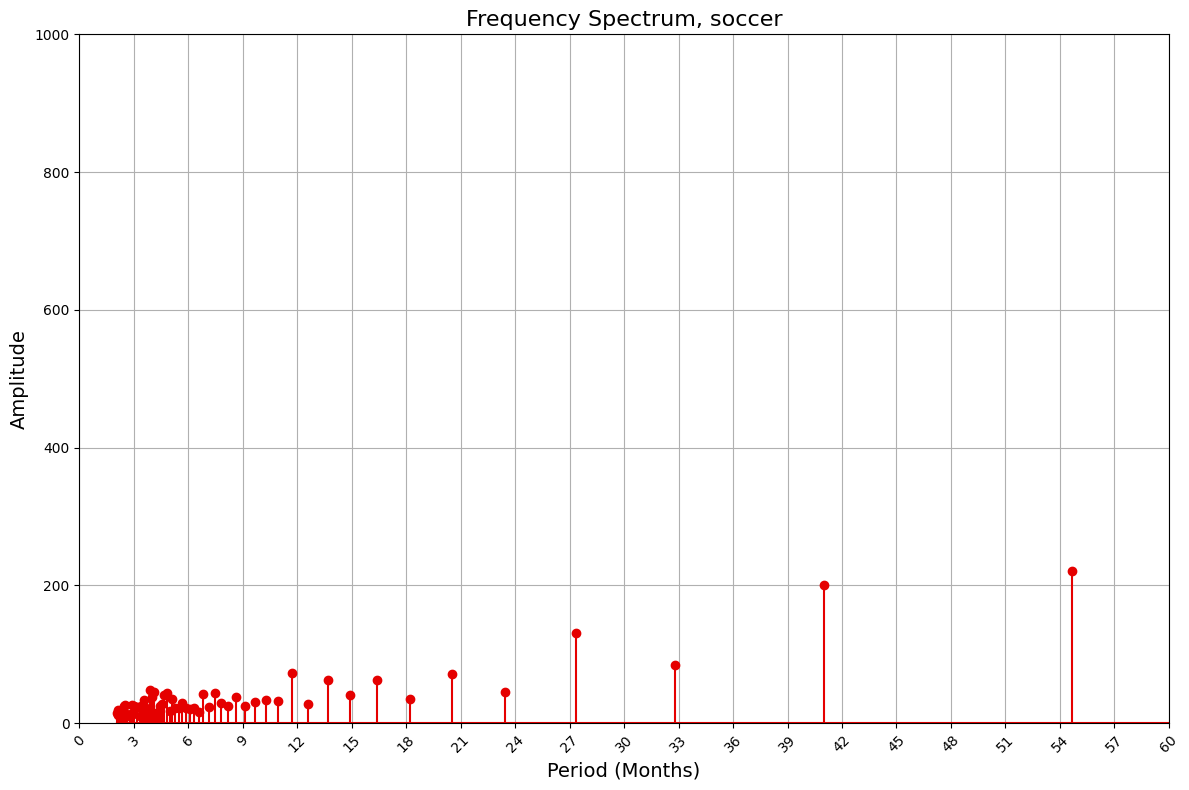

periodic analysis
len 159
[159.          79.5         53.          39.75        31.8
  26.5         22.71428571  19.875       17.66666667  15.9
  14.45454545  13.25        12.23076923  11.35714286  10.6
   9.9375       9.35294118   8.83333333   8.36842105   7.95
   7.57142857   7.22727273   6.91304348   6.36         6.11538462
   5.88888889   5.67857143   5.48275862   5.3          5.12903226
   4.96875      4.81818182   4.67647059   4.54285714   4.07692308
   3.975        3.78571429   3.69767442   3.61363636   3.53333333
   3.38297872   3.3125       3.24489796   3.11764706   3.05769231
   3.           2.94444444   2.89090909   2.83928571   2.78947368
   2.74137931   2.69491525   2.65         2.60655738   2.56451613
   2.52380952   2.484375     2.44615385   2.40909091   2.37313433
   2.33823529   2.30434783   2.27142857   2.23943662   2.20833333
   2.14864865   2.12         2.09210526   2.06493506   2.03846154]
[789.58613498 427.50155056 321.83849784 198.07654082 146.59229215
 112.86631

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


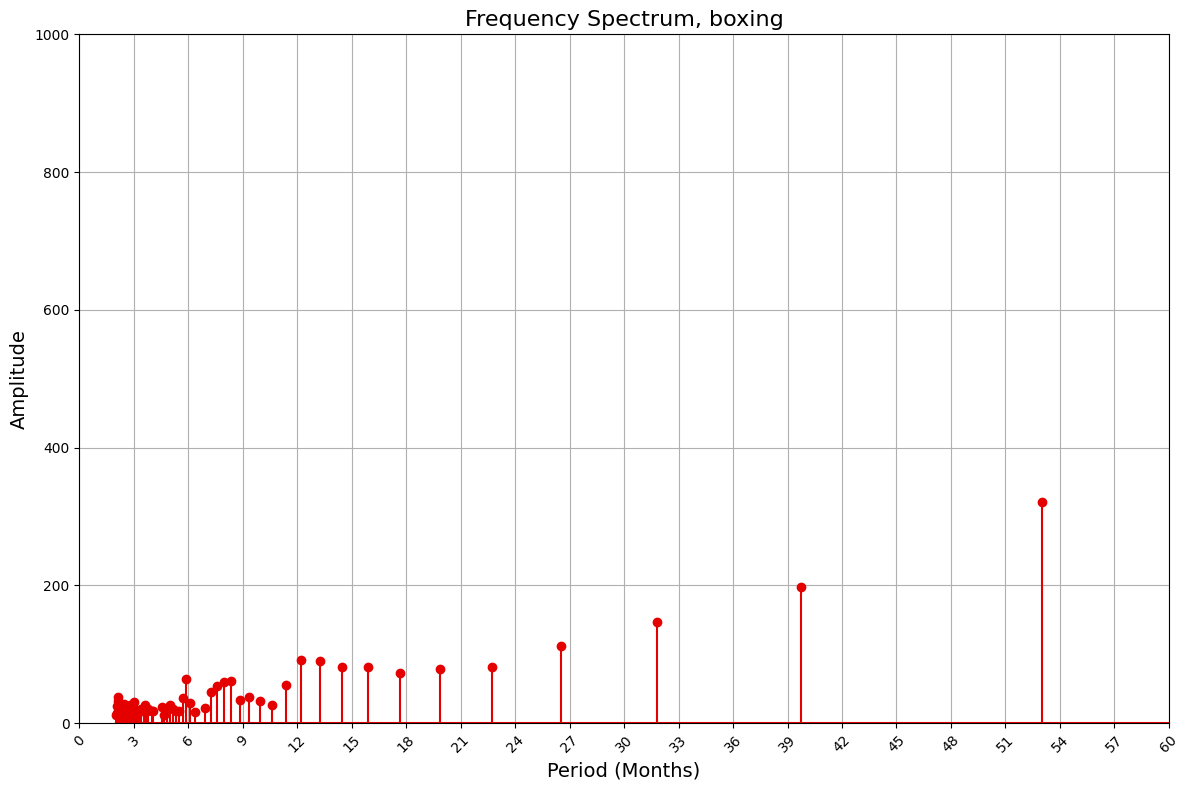

periodic analysis
len 159
[159.          79.5         53.          39.75        31.8
  26.5         22.71428571  19.875       17.66666667  15.9
  14.45454545  13.25        12.23076923  11.35714286  10.6
   9.9375       9.35294118   8.83333333   8.36842105   7.95
   7.57142857   7.22727273   6.91304348   6.625        6.36
   6.11538462   5.88888889   5.67857143   5.48275862   5.3
   5.12903226   4.96875      4.81818182   4.67647059   4.54285714
   4.41666667   4.2972973    4.18421053   4.07692308   3.975
   3.78571429   3.69767442   3.61363636   3.53333333   3.38297872
   3.3125       3.24489796   3.18         3.11764706   3.
   2.94444444   2.89090909   2.83928571   2.78947368   2.69491525
   2.65         2.56451613   2.52380952   2.484375     2.44615385
   2.40909091   2.33823529   2.30434783   2.27142857   2.20833333
   2.12         2.09210526   2.06493506]
[444.09287931 361.26302156 205.26522638 181.25294154 171.43334482
  70.71606452 102.1467669   54.77870234  58.8280494   34.18116

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


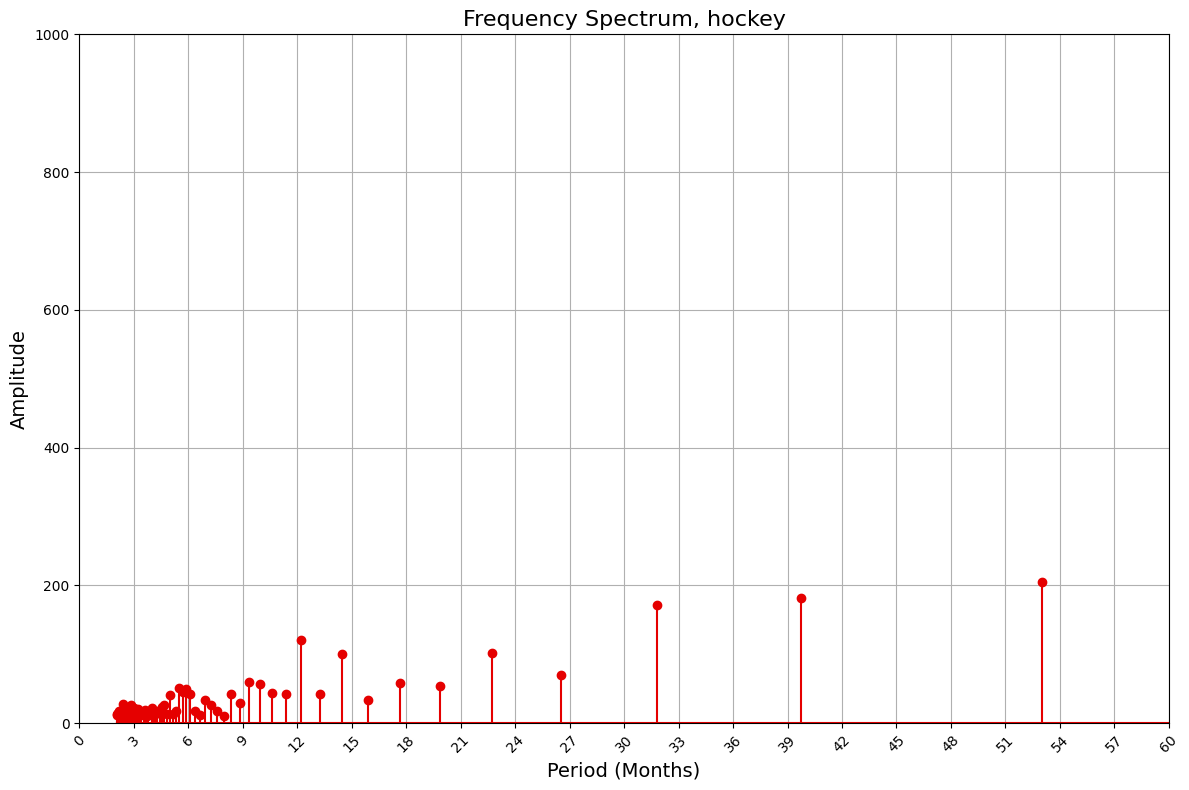

periodic analysis
len 161
[161.          80.5         53.66666667  40.25        32.2
  26.83333333  23.          20.125       17.88888889  16.1
  14.63636364  13.41666667  12.38461538  11.5         10.73333333
  10.0625       9.47058824   8.94444444   8.47368421   8.05
   7.66666667   7.31818182   7.           6.70833333   6.44
   6.19230769   5.96296296   5.75         5.55172414   5.36666667
   5.19354839   5.03125      4.87878788   4.73529412   4.6
   4.47222222   4.35135135   4.23684211   4.12820513   4.025
   3.92682927   3.83333333   3.74418605   3.65909091   3.57777778
   3.5          3.42553191   3.35416667   3.28571429   3.22
   3.15686275   3.09615385   3.03773585   2.98148148   2.92727273
   2.875        2.8245614    2.77586207   2.72881356   2.68333333
   2.63934426   2.59677419   2.55555556   2.515625     2.47692308
   2.43939394   2.40298507   2.36764706   2.33333333   2.3
   2.26760563   2.23611111   2.20547945   2.17567568   2.14666667
   2.11842105   2.09090909   2.0641

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


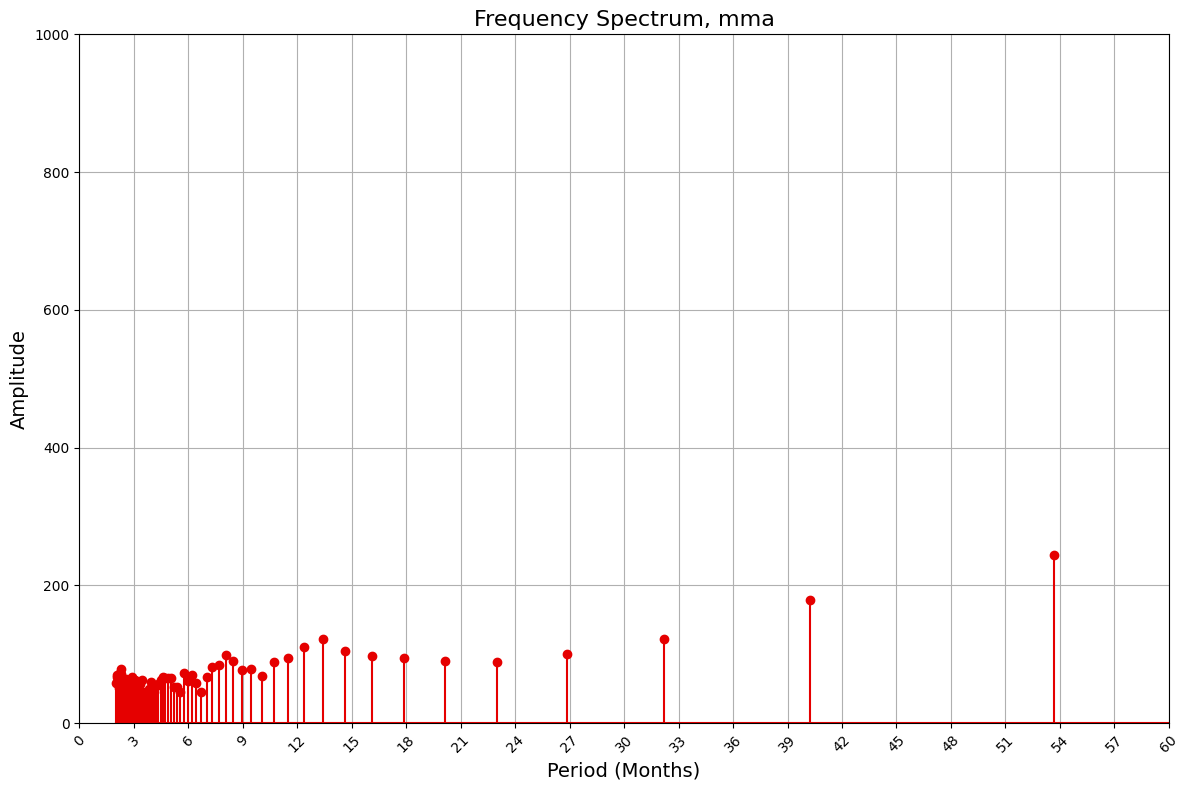

periodic analysis
len 159
[159.          79.5         53.          39.75        31.8
  26.5         22.71428571  19.875       17.66666667  15.9
  14.45454545  13.25        12.23076923  11.35714286  10.6
   9.9375       9.35294118   8.83333333   7.95         7.57142857
   6.91304348   6.625        6.11538462   5.88888889   2.60655738]
[179.54643004  72.15518351  69.02924123  73.04551654  52.33373232
  28.9717872   38.98805084  22.49185394  17.81171414  16.08353916
  10.32391342  27.44704358  42.11937671  17.39123426  20.02617324
  18.4828591   12.7078194   14.4470921   13.04627909  11.07999975
  10.70183415  14.97606395  12.84765565  17.97255952  10.28891354]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


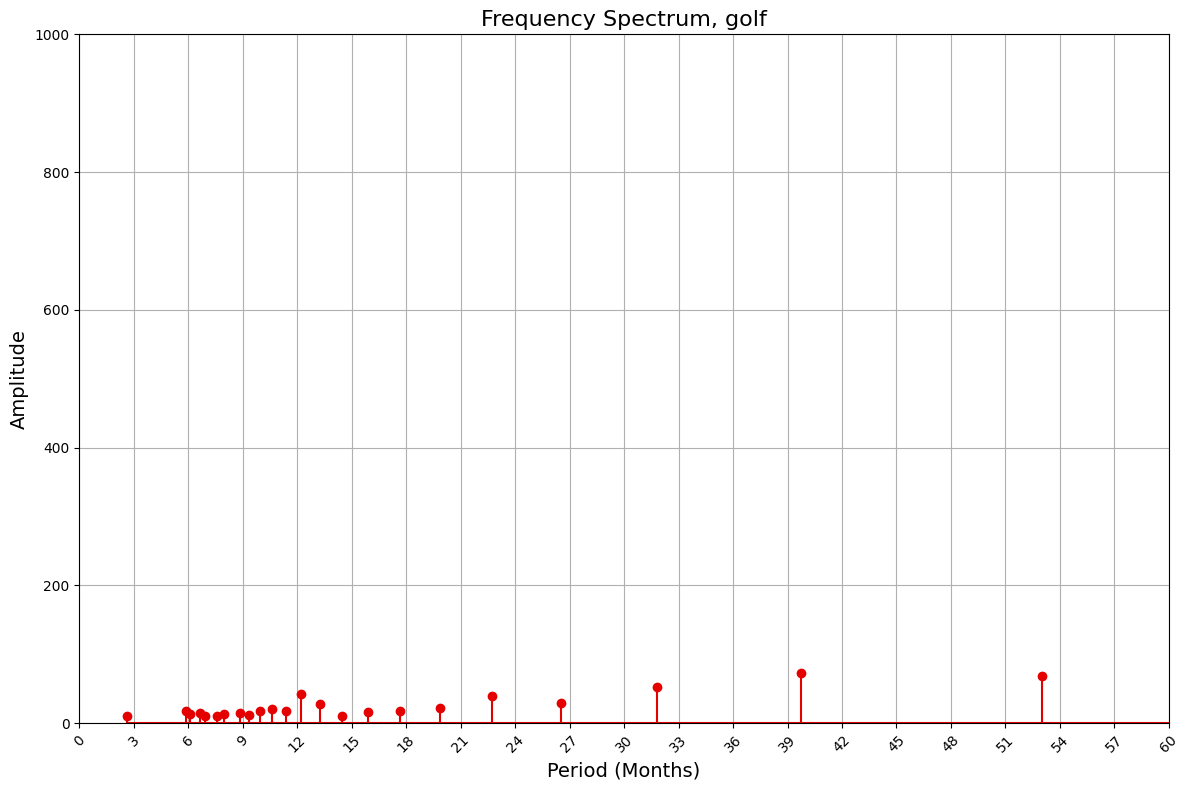

periodic analysis
len 157
[157.          78.5         52.33333333  39.25        31.4
  26.16666667  22.42857143  19.625       15.7         14.27272727
  13.08333333  12.07692308  11.21428571  10.46666667   9.8125
   9.23529412   8.72222222   8.26315789   7.85         7.13636364
   6.82608696   6.54166667   6.28         6.03846154   5.81481481
   5.60714286   5.4137931    5.23333333   5.06451613   4.90625
   4.75757576   4.61764706   4.48571429   4.36111111   4.24324324
   4.13157895   4.02564103   3.925        3.82926829   3.41304348
   3.34042553   3.27083333   3.20408163   3.14         3.07843137
   3.01923077   2.85454545   2.80357143   2.75438596   2.70689655
   2.66101695   2.61666667   2.57377049   2.53225806   2.49206349
   2.453125     2.41538462   2.09333333   2.06578947   2.03896104]
[544.72192877 360.48669588 245.00440043 225.15131732 183.36928839
 118.03816203  55.61060048  29.74261569  53.0018666   63.51013404
  88.47878    115.76672872  80.96882758  56.85932549  51.706177

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


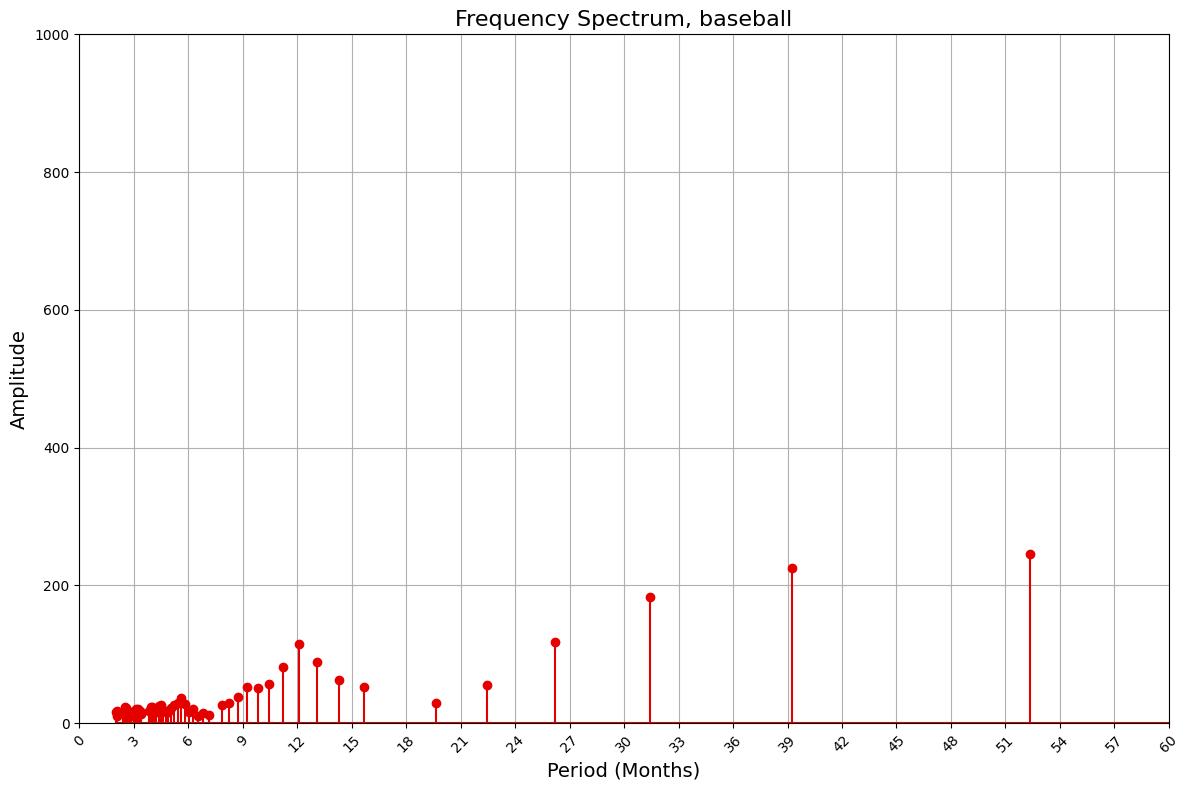

periodic analysis
len 157
[157.          78.5         52.33333333  39.25        31.4
  26.16666667  22.42857143  19.625       17.44444444  15.7
  14.27272727  13.08333333  12.07692308   9.23529412   8.72222222
   7.85         7.47619048   6.82608696   6.54166667   6.28
   6.03846154   5.81481481   5.60714286   4.02564103   3.925
   3.82926829   3.73809524   3.48888889   3.41304348   3.20408163
   3.14         3.07843137   3.01923077   2.96226415   2.90740741
   2.85454545   2.80357143   2.66101695   2.49206349   2.453125
   2.41538462   2.37878788   2.34328358   2.30882353   2.27536232
   2.18055556   2.15068493   2.09333333   2.06578947   2.03896104]
[118.68631341 106.27335114  53.07614059  30.49338487  17.12802312
  28.51276229  25.36928465  19.71049902  26.86212608  20.44496373
  14.92082751  26.03136027  18.36660939  12.77045997  11.97336507
  18.1649954   10.52259859  12.41477276  16.53975495  33.36852255
  26.58914203  35.11755654  13.66141659  18.86024028  26.48426919
  13.73517

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


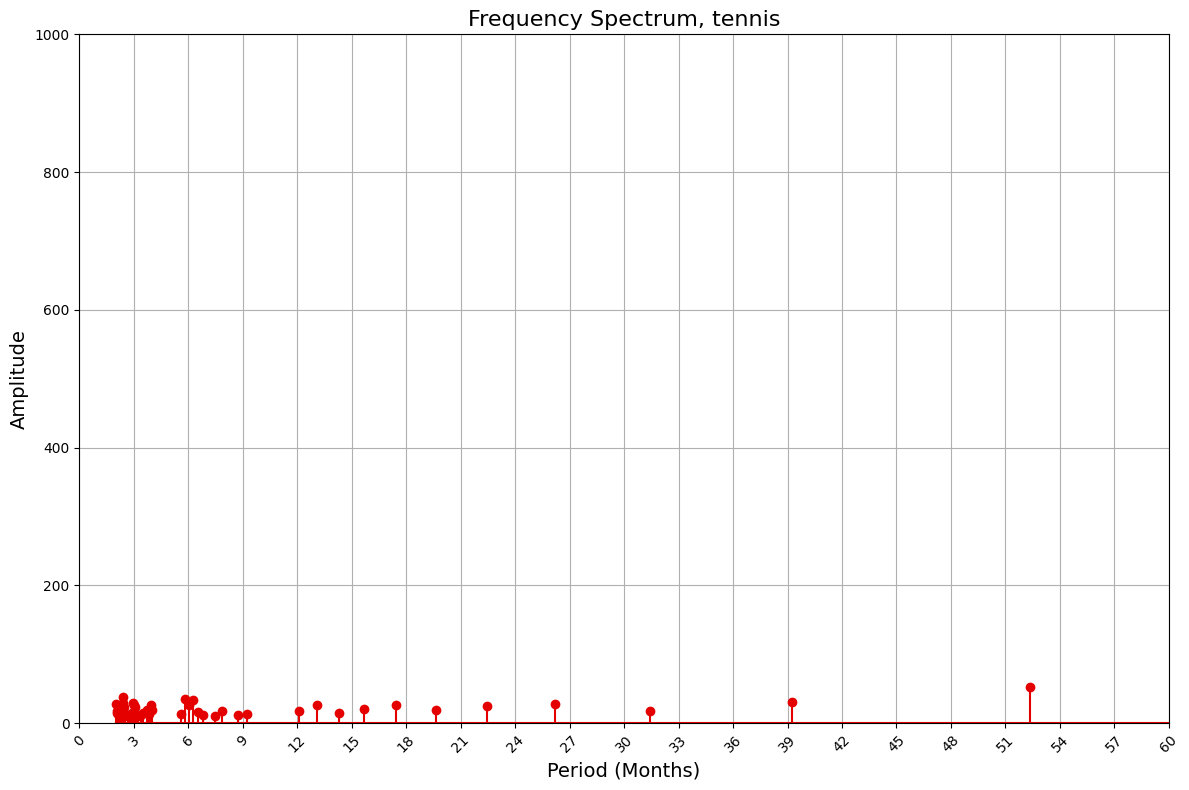

periodic analysis
len 146
[146.          73.          48.66666667  36.5         29.2
  24.33333333  20.85714286  18.25        16.22222222  14.6
  13.27272727  12.16666667  11.23076923   9.125        8.58823529
   8.11111111   7.68421053   7.3          6.95238095   6.08333333
   3.10638298]
[71.13930769 79.82156972 35.71348516 31.30328283 22.26284478 24.73571365
 21.06828154 26.71814081 23.48674463 24.02180831 21.66597952 21.43504424
 11.68394618 18.0957929  15.53029459 19.21065079 13.21211248 11.66854478
 10.86621073 11.61581483 10.40989005]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


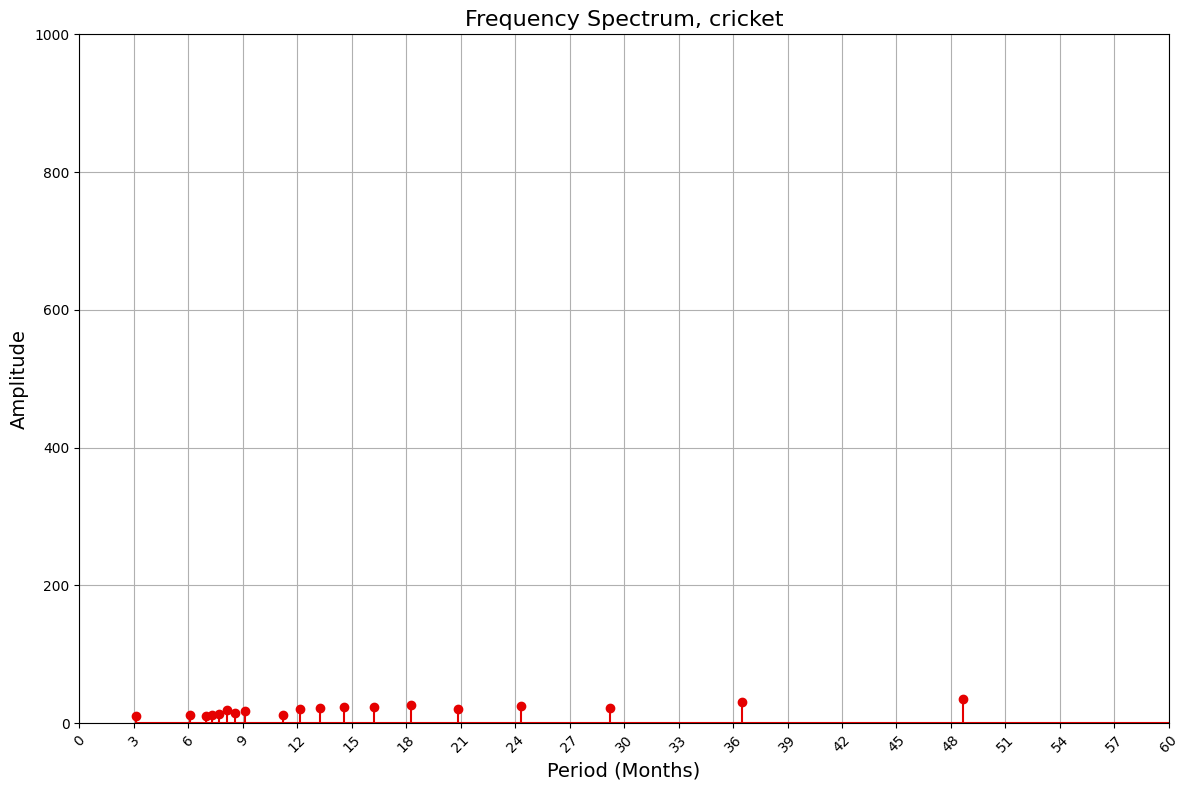

periodic analysis
len 154
[154.          77.          51.33333333  38.5         30.8
  22.          12.83333333   9.625        6.16         5.92307692
   5.5          5.31034483   3.01960784   2.96153846   2.48387097]
[89.80988198 41.03050007 39.97698964 19.18478181 30.4101086  18.63869813
 11.10603834 12.42512108 13.68562896 29.07439879 10.40949774 12.82623087
 14.30833185 11.23450454 10.47249766]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


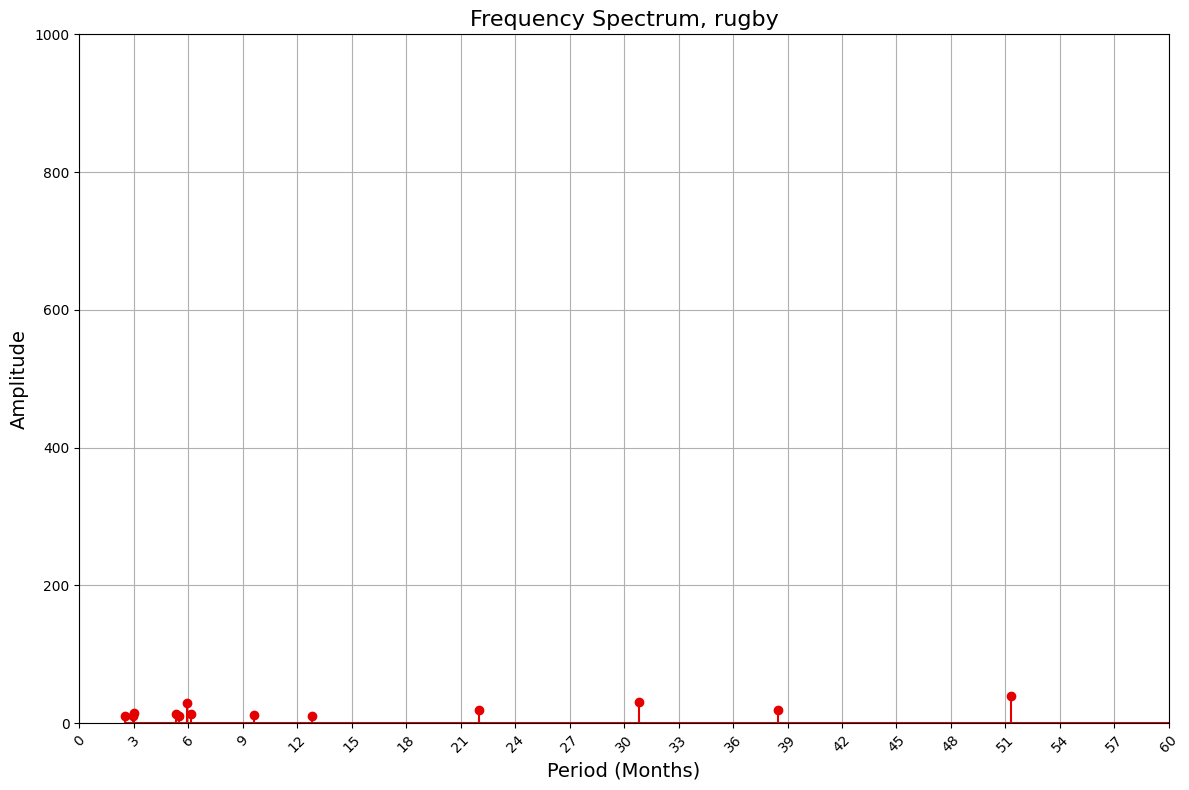

periodic analysis
len 163
[163.          81.5         54.33333333  40.75        32.6
  27.16666667  23.28571429  20.375       18.11111111  16.3
  13.58333333  12.53846154  11.64285714  10.86666667  10.1875
   9.58823529   9.05555556   8.57894737   8.15         7.76190476
   7.40909091   7.08695652   6.79166667   6.52         6.26923077
   6.03703704   5.82142857   5.62068966   5.43333333   5.25806452
   5.09375      4.79411765   4.65714286   4.52777778   4.40540541
   4.28947368   4.17948718   4.075        3.97560976   3.79069767
   3.70454545   3.62222222   3.39583333   3.32653061   3.26
   3.19607843   3.13461538   3.0754717    3.01851852   2.96363636
   2.91071429   2.85964912   2.81034483   2.76271186   2.71666667
   2.67213115   2.62903226   2.58730159   2.546875     2.50769231
   2.46969697   2.43283582   2.39705882   2.36231884   2.32857143
   2.26388889   2.23287671   2.2027027    2.14473684   2.11688312
   2.08974359   2.06329114   2.0375    ]
[141.95471333 107.6807641   78.18

/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


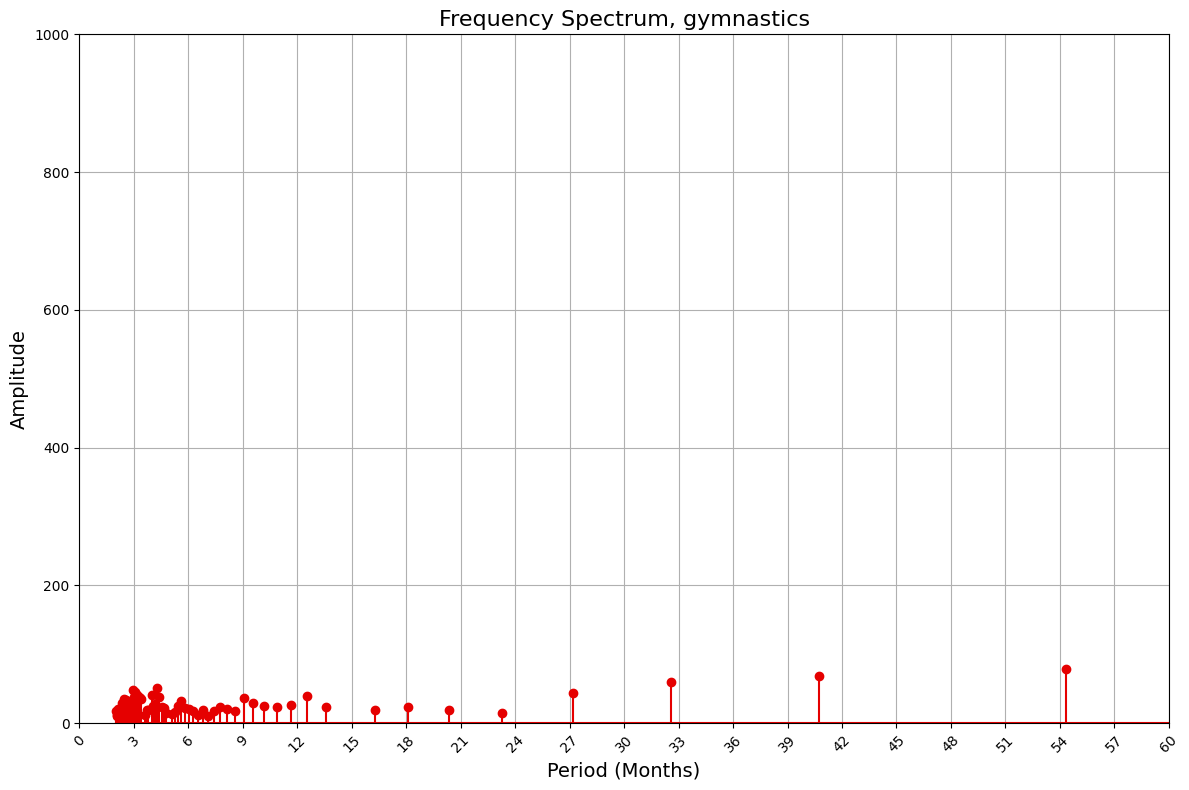

periodic analysis
len 147
[147.          73.5         49.          36.75        24.5
  21.          16.33333333  13.36363636  12.25        11.30769231
   8.16666667   6.125        5.88         3.97297297   3.86842105]
[64.17988685 31.81308115 21.1987661  24.53235841 14.966363   18.69425989
 10.68958842 14.01306435 22.25322481 28.85491948 11.15217352 11.25502684
 10.52133847 12.37239413 11.22774991]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


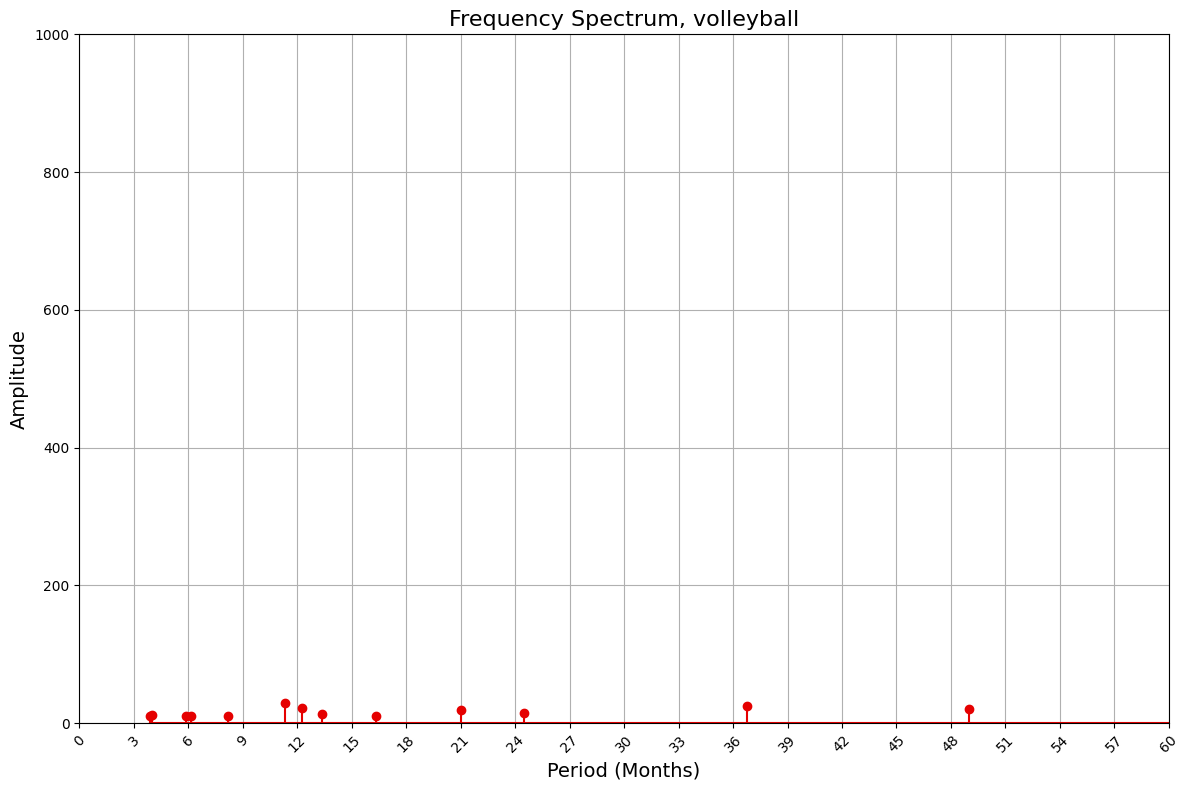

periodic analysis
len 160
[160.          80.          53.33333333  40.          22.85714286
  14.54545455  12.30769231  11.42857143  10.66666667  10.
   9.41176471   8.           6.4          6.15384615   5.92592593
   5.51724138   5.           4.70588235   4.21052632   4.
   3.80952381   3.40425532   3.01886792   2.96296296   2.3880597 ]
[85.8963273  27.12847459 13.50845759 14.9069812  15.8931243  17.65243413
 34.93693469 24.15647357 20.50025926 15.36382788 10.53241398 11.3463043
 18.35161962 12.58142881 31.79554031 19.02178965 10.00992577 12.11178634
 12.85181373 24.43942128 15.81858239 11.37258479 12.4307284  15.37778853
 10.49927629]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


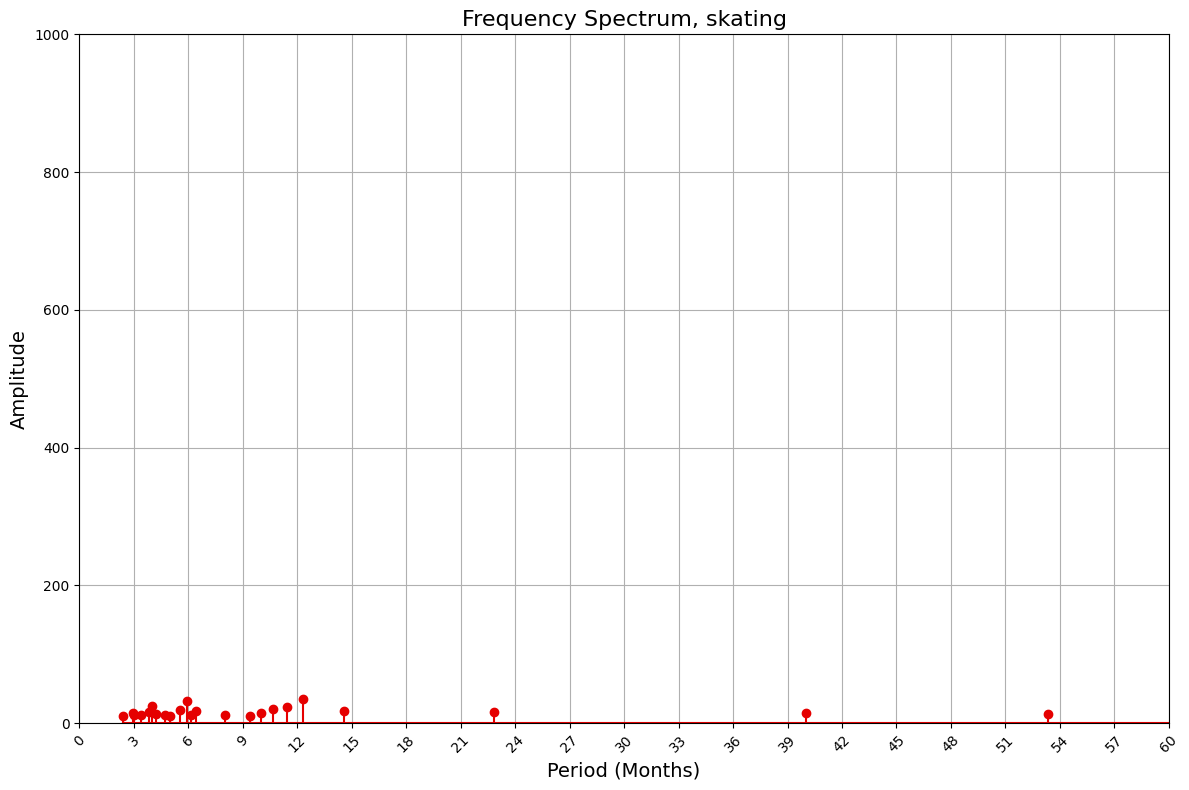

periodic analysis
len 158
[158.          79.          52.66666667  39.5         26.33333333
  19.75        15.8         12.15384615  11.28571429   9.875
   7.18181818   6.32         6.07692308   5.85185185   5.44827586
   4.27027027   4.05128205   3.95         3.36170213   3.29166667
   3.09803922   2.98113208   2.92592593   2.77192982   2.43076923
   2.39393939   2.35820896   2.16438356]
[90.49761915 26.81796116 35.80587183 19.04046    16.29076162 16.79939937
 19.38615583 22.29352314 11.49008689 12.306398   15.44808202 22.06009775
 32.43497865 20.94358926 12.07257225 14.74537422 17.5520515  11.20032665
 11.6686063  10.74630273 10.87654828 10.30588384 13.62275989 10.97173404
 10.93058945 10.06884935 12.60851811 12.07405977]


/var/folders/m7/41nytqlj2xz8_vx7g_hdxdfm0000gn/T/ipykernel_6502/3502719883.py:41: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / positive_frequencies


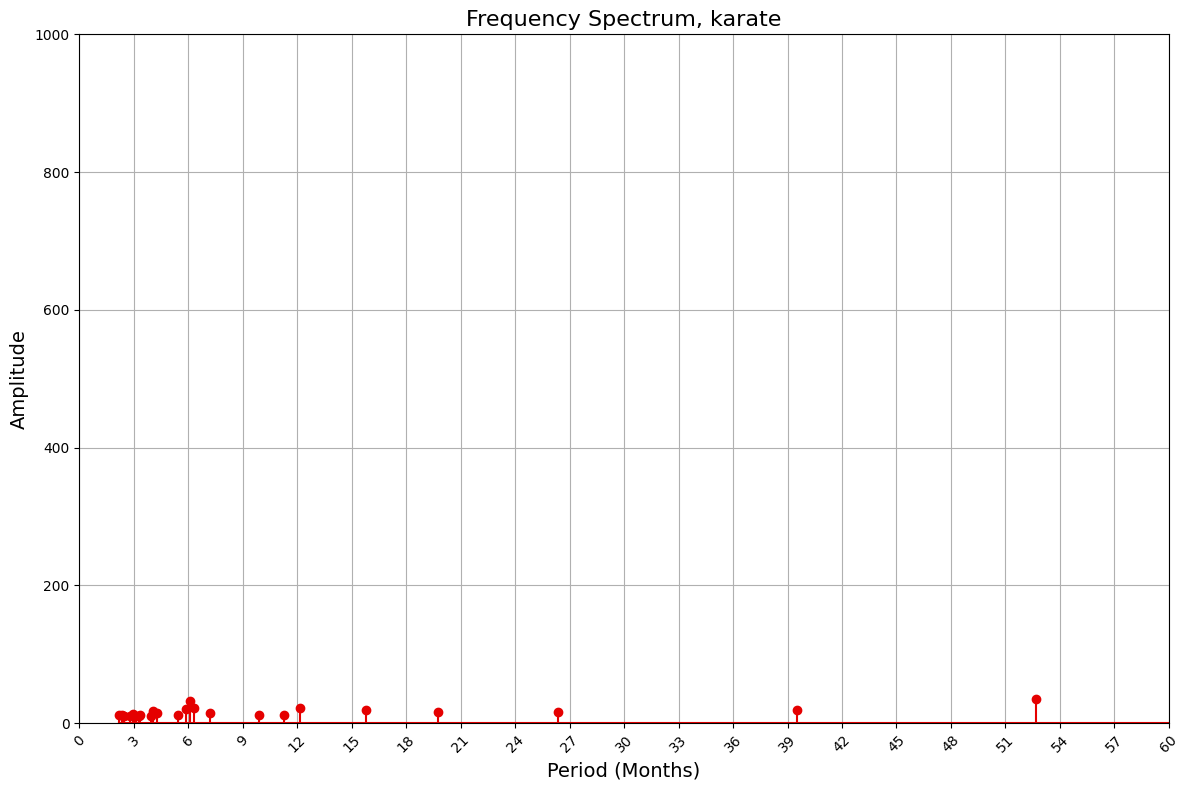

In [16]:
sportttt=['golf']
for sport in target_sports:
    df_sport_category_metadata=target_sport_data[target_sport_data['tags'].apply(lambda x: sport in x)]
    sport_analysis(target_sport_data,df_sport_category_metadata,sport)